# Variable lithology erosion model

This notebook contains an implementation of a simple landscape evolution model. The model has two layers: a soft sedimentary cover (high $K$) overlying a hard crystalline basement (low $K$). The purpose is to investigate how continuous exumation of this soft-on-hard material would be manifest in exhumation history, and thus in low-temperature thermochronometers such as (U-Th)/He.

Written by Greg Tucker and Becky Flowers starting October 2017

Step 1: define a TwoLayerErosionModel class

In [89]:
import numpy as np
from landlab import load_params
from landlab.components import (FlowAccumulator, FastscapeEroder, 
                                DepressionFinderAndRouter, LinearDiffuser)
from landlab.io.netcdf import write_raster_netcdf

class TwoLayerErosionModel(object):
    """
    A TwoLayerErosionModel is a simple model for erosion and landscape 
    evolution that manifests a soft sediment cover (high erodibility) over
    a hard crystalline basement (low erodibility).
    """

    def __init__(self, 
                 input_file=None, 
                 params=None):
        """
        Handles inputs, sets params.
        """

        # Make sure user has given us an input file or parameter dictionary
        # (but not both)
        if input_file is None and params is None:
            print('You must specify either an input_file or params dict')
            sys.exit(1)
        if input_file is not None and params is not None:
            print('ErosionModel constructor takes EITHER')
            print('input_file or params, but not both.')
            sys.exit(1)

        # If we have an input file, let's read it
        if input_file is None:
            self.params = params
        else:
            self.params = load_params(input_file)                

        try:
            nr = self.params['number_of_node_rows']
            nc = self.params['number_of_node_columns']
            dx = self.params['node_spacing']
        except KeyError:
            print('Warning: no DEM or grid shape specified. '
                    'Creating simple raster grid')
            nr = 4
            nc = 5
            dx = 1.0

        from landlab import RasterModelGrid
        self.grid = RasterModelGrid((nr, nc), dx)
        self.z = self.grid.add_zeros('node', 'topographic__elevation')
        np.random.seed(0)
        self.z[:] = np.random.rand(self.z.size)

        # initialize model time. 
        self.model_time = 0.

        # Add fields for initial topography and cumulative erosion depth
        self.z0 = self.grid.add_zeros('node', 'initial_topographic__elevation')
        self.z0[:] = self.z  # keep a copy of starting elevation
        self.cum_ero = self.grid.add_zeros('node', 'cumulative_erosion__depth')
        
        # Set up the field of erodibility values
        self.setup_erodibility(params)

        # Set up components
        self.create_and_initialize_components(params)
        
        # Read and remember uplift rate
        self.uplift_rate = params['uplift_rate']
        
        # Variable for mean elev vs time
        self.mean_elev = np.zeros(int(params['run_duration'] / 
                                  params['dt']) + 1)

    def setup_erodibility(self, params):
        """Create and initialize field for erodibility."""
        self.K_soft = params['K_soft']
        self.K_hard = params['K_hard']
        self.contact_depth = params['lithologic_contact__depth']
        self.erodibility = self.grid.add_zeros('node', 'erodibility')
        self.erodibility[:] = self.K_soft

    def update_erodibility_field(self):
        """Update erodibilities based on exposed lithology."""
        basement_exposed = np.where(self.cum_ero > self.contact_depth)[0]
        self.erodibility[:] = self.K_soft
        self.erodibility[basement_exposed] = self.K_hard

    def create_and_initialize_components(self, params):
        """Create and initialize the process components: flow routing,
        channel erosion, hillslope erosion."""

        # Instantiate a FlowAccumulator with DepressionFinderAndRouter using D8 method
        self.flow_router = FlowAccumulator(self.grid,
                                           flow_director='D8',
                                           depression_finder = DepressionFinderAndRouter)

        # Instantiate a FastscapeEroder component
        self.eroder = FastscapeEroder(self.grid, 
                                      K_sp=self.erodibility,
                                      m_sp=params['m_sp'],
                                      n_sp=params['n_sp'])

        # Instantiate a LinearDiffuser component
        self.diffuser = LinearDiffuser(self.grid,
                                       linear_diffusivity=params['linear_diffusivity'])

    def calculate_cumulative_change(self):
        """Calculate cumulative node-by-node changes in elevation.
        
        Store result in grid field.
        """
        self.cum_ero = self.z0 - self.z

    def write_output(self, params, field_names=None):
        """Write output to file (currently netCDF)."""
        
        # Exclude fields with int64 (incompatible with netCDF3)
        if field_names is None:
            field_names = []
            for field in self.grid.at_node:
                if type(self.grid.at_node[field][0]) is not np.int64:
                    field_names.append(field)
        
        self.calculate_cumulative_change()
        filename = self.params['output_filename'] + str(self.iteration).zfill(4) \
                    + '.nc'
        write_raster_netcdf(filename, self.grid, names=field_names, format='NETCDF4')

    def run_one_step(self, dt):
        """
        Run each component for one time step.
        """
        
        # Route flow
        self.flow_router.run_one_step()

        # Get IDs of flooded nodes, if any
        flooded = np.where(self.flow_router.depression_finder.flood_status==3)[0]

        # Update erodibility field based on exposure of basement
        self.update_erodibility_field()

        # Do some erosion (but not on the flooded nodes)
        self.eroder.run_one_step(dt, flooded_nodes=flooded)

        # Do some soil creep
        self.diffuser.run_one_step(dt)
        
        # Do some uplift
        self.z[self.grid.core_nodes] += self.uplift_rate * dt
        self.z0[self.grid.core_nodes] += self.uplift_rate * dt

        # Update cumulative erosion
        self.calculate_cumulative_change()

        # calculate model time
        self.model_time += dt
        
        # Remember mean elevation and cum elev
        self.mean_elev[int(round(self.model_time / dt))] = np.mean(self.z[self.grid.core_nodes])
        self.mean_cum_elev[int(round(self.model_time / dt))] = np.mean(self.z[self.grid.core_nodes])

    def finalize(self):
        """
        Finalize model
        """
        pass
    
    def run_for(self, dt, runtime):
        """
        Run model without interruption for a specified time period.
        """
        elapsed_time = 0.
        keep_running = True
        while keep_running:
            if elapsed_time+dt >= runtime:
                dt = runtime-elapsed_time
                keep_running = False
            self.run_one_step(dt)
            elapsed_time += dt

    def run(self, output_fields=None):
        """
        Run the model until complete.
        """
        total_run_duration = self.params['run_duration']
        output_interval = self.params['output_interval']
        self.iteration = 1
        time_now = self.model_time
        while time_now < total_run_duration:
            next_run_pause = min(time_now + output_interval, total_run_duration)
            self.run_for(self.params['dt'], next_run_pause - time_now)
            time_now = next_run_pause
            self.write_output(self.params, field_names=output_fields)
            self.iteration += 1
            
        self.finalize()

In [104]:
my_params = {
    'K_soft' : 0.01,
    'K_hard' : 0.0001,
    'm_sp' : 0.5,
    'n_sp' : 1.0,
    'lithologic_contact__depth' : 3000.0,
    'run_duration' : 3.05e5,
    'output_interval' : 3.05e5,
    'linear_diffusivity' : 0.01,
    'dt' : 1000.0,
    'number_of_node_rows' : 60,
    'number_of_node_columns' : 100,
    'node_spacing' : 1000.0,
    'uplift_rate' : 0.01,
    'output_filename' : 'test_two_layer_model.nc'
}

In [105]:
model = TwoLayerErosionModel(params=my_params)

In [106]:
model.run()

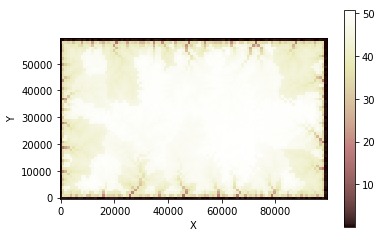

In [107]:
from landlab import imshow_grid
%matplotlib inline

imshow_grid(model.grid, model.z)

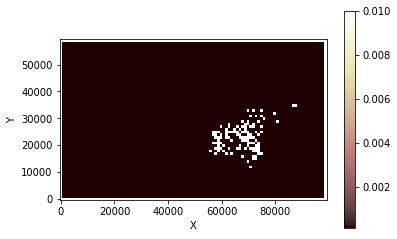

In [108]:
imshow_grid(model.grid, model.erodibility)

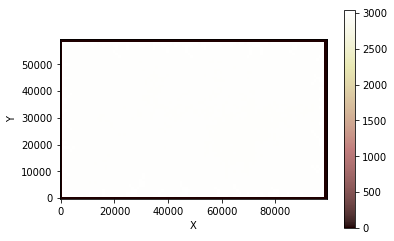

In [109]:
imshow_grid(model.grid, model.cum_ero)

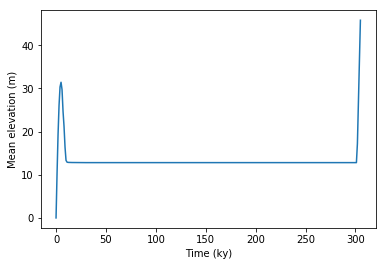

In [111]:
import matplotlib.pyplot as plt

plt.plot(model.mean_elev)
plt.xlabel('Time (ky)')
plt.ylabel('Mean elevation (m)')